# UMAP Lecture

UMAP stands for Uniform Manifold Approximation and Projection and is a dimensionality reduction method. In biology we often deal with thousands of genes per cell. This makes each cell a point in a 1000-dimensional space or also called feature space. If we want to plot a cell with its 1000 genes we need to first reduce those 1000 dimensions or features down to only 2 or 3 since our human brain cannot visualize much more than that. \
Take care however that those reduced features do not necessarily correspond to the original genes in the cell but are more likely a combination of all the previous 1000 genes.

Let's look at the famous *iris* data set of 3 different kinds of flower species. Each flower type has 4 different features, namely sepal length, sepal width, petal length and petal width.

In [21]:
data("iris")

head(iris)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa


## (1) PCA - Principal Component Analysis

Now we want to visualize each row of our table, i.e. each sample, in a 2 dimensional scatter plot. Therefore we calculate the first and second principal component of this data set. The first principal component is again a combination of our 4 features that specifically lies in the direction of the highest variance. The figure below shows the spread of the features in a 2D space and the corresponding direction of the principal components for a made-up data set (not our iris data set yet).

Example of first two principal components of an arbitrary artificial data set. Notice how the first principal component (PC1) shows in the direction of the highest spread/variation of the data.

![](./lecture_plots/pca_components.png)

Now we do the same but for our iris data set

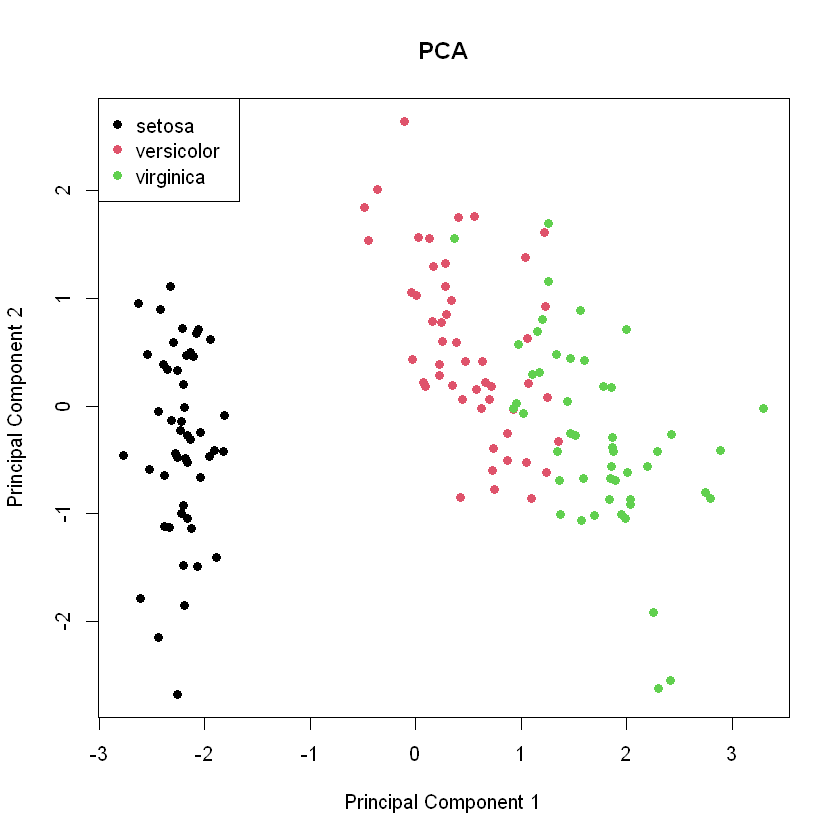

In [2]:
pc <- prcomp(iris[,-5], center = TRUE, scale. = TRUE)

plot(pc$x[,1], pc$x[,2], col=iris[,5], pch=16, xlab="Principal Component 1", ylab="Principal Component 2", main="PCA")
legend("topleft", legend=levels(iris$Species), col=1:3, pch=16)

We have successfully reduced our 4 dimensional data set into a 2 dimensional space. For visual guidance the class of the samples was manually added, otherwise it would be hard for the viewer to confirm a good clustering result. PCA does not classify the samples by itself. Just like UMAP it is a unsupervised machine learning algorithm that means that no labels or classes (in our case flower species) are presented to the algorithm. Notice how for the iris data set only two variables, here PC1 and PC2, are enough information to separate our data decently into distinguishable clusters.

Similar to PCA, UMAP can also reduce the 4 dimensions down to only 2 dimensions. The method of UMAP is harder to understand and more sophisticated than simply looking at the direction of maximal variation. On the other hand the results of UMAP currently often show best clustering results among the dimensionality reduction algorithms. \
When applying UMAP <a id='first_umap_figure'></a> to the iris data set tighter clusters and more separation between labels can be observed.

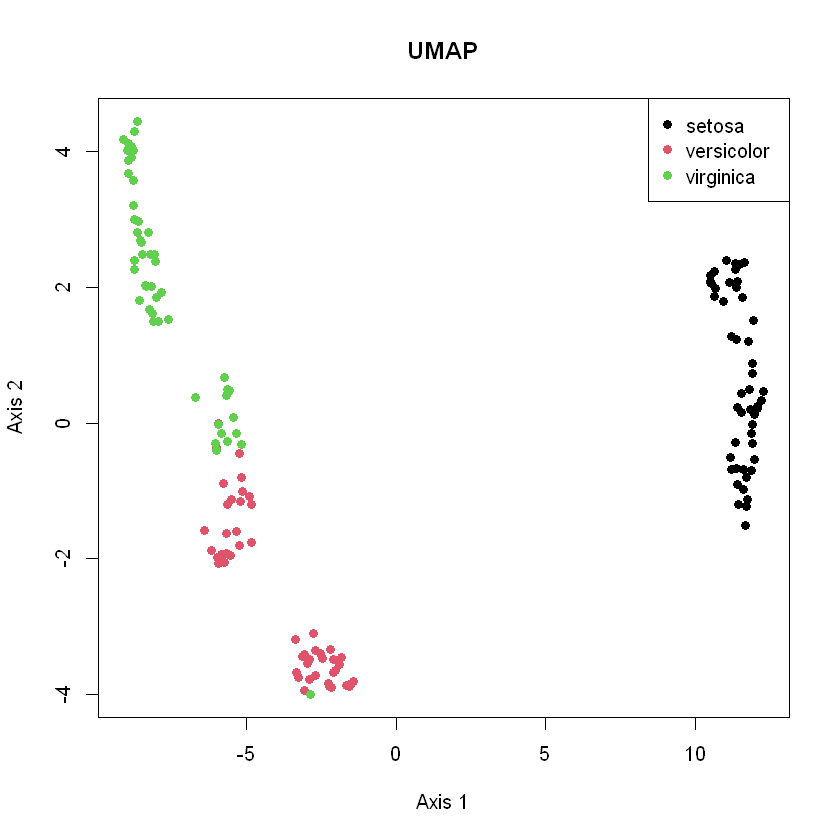

In [57]:
library(umap)

iris.umap <- umap(iris[,-5])

plot(iris.umap$layout[,1], iris.umap$layout[,2], col=iris[,5], pch=16, xlab="Axis 1", ylab="Axis 2", main="UMAP")
legend("topright", legend=levels(iris$Species), col=1:3, pch=16)

Judging on the quality of a dimensionality reduction algorithm is not super straight forward when trying to compare results of for example PCA and UMAP. The idea is that the high dimensional structure should be preserved as best as possible in the low dimensional space (often 2D or 3D). For now better separation and tighter clusters shown by UMAP will suffice.

Interestingly UMAP manages to find clusters that are both more separated and also more dense and therefore make for easier separation between clusters. This could be useful if the goal would be to label certain clusters. Later we will learn how we can influence clustering result of UMAP, i.e. if we want to emphasis on retaining global or local structure in the low dimensional space. \
Also notice how the axes of the plot no longer have any mathematical meaning anymore, unlike in PCA where they corresponded to the variance in the data.

## (2) UMAP - High dimensional represenatation

Before UMAP can reduce the dimensionality of the data set it has to construct a so called graph of the data. A graph relates the structure of the data in real space. For example if two samples are close together because they have similar values in all of their features then the graph would show a strong connection between those two points. \
We are going to look at the graph that UMAP constructs on the artificial data of a sinus curve. Although this sinus curve is only in 2 dimensions, it is supposed to represent the high dimensional space that we want to reduce, i.e. to a single dimension in this case.

![](./lecture_plots/how_umap_works_raw_data.png)

The UMAP algorithm starts off by looking for its k-nearest neighbors for each of the above data points. Visually one can think of this as constructing a sphere around each data point where this sphere includes only the k-nearest neighbors (including the middle point itself as one of the k neighbors as well). \
Following figure shows this process for k=5 nearest neighbors. Each circle should only contain 5 points in total.

![](./lecture_plots/how_umap_works_local_metric_open_cover.png)



So far we have a connection between each point and its 5 nearest neighbors (itself included). Now we would like to assign an importance to some of those connections, also called edges, between two points. \
If two points are particularly close together in our data set we want them to have a strong connection/edge and if they are further apart within the circle then they should have a weaker edge. We can express this strength of the edge by a number called *weight*. The higher the weight the closer together two samples are. \
In practice one can achieve this variation in strength by introducing an exponential decay with increasing distance from the center point. \
The next figure visualizes this exponential decay with a higher saturation in the center and a fading towards the circumference.


![](./lecture_plots/how_umap_works_fuzzy_open_cover.png)


The last thing we have to consider now is, that in high dimensional spaces the distance between two arbitrary points tend to be almost the same. This is called the *curse of dimensionality* and describes the phenomenon that the distance of one sample to its next nearest neighbor is almost the same as its 10-nearest neighbor. \
Hence we would like to clearly distinguish between the next nearest neighbor and the rest. UMAP implements this by assigning the nearest neighbor an edge weight of 1, i.e. fully connected, and after this nearest neighbor the edge weight decreases exponentially as before and finally becomes zero when reaching the edge of the circle.

![](./lecture_plots/how_umap_works_umap_open_cover.png)

Now all that is left to do is draw a line for each point to its k-nearest neighbors (itself included) and make the strength of the connection between two points visible by different linewidths.
The connection strength for each point to its nearest neighbor is always the same, namely 1. 

![](./lecture_plots/how_umap_works_umap_graph.png)

### Step by step example

Now we apply the graph theory from above and look at concrete numbers of distance and edge weights. For this we look again at only a 2 dimensional artificial data set, that we want to reduce to a 1 dimensional space.

#### Graph construction

We begin by finding the k-nearest neighbors of each data point. Before we start the UMAP algorithm we have to choose a k value. For simplicity reasons let's choose $k=3$ but we could have picked any other value $k$ as well as long as it is bigger than $1$. Looking at the figure below it is clear that the nearest neighbor of sample A is B & C. Nearest neighbor for B is A & C and so on. \
The UMAP algorithm finds these nearest neighbors by picking one sample and calculating the distance to all other samples (itself included). The three shortest distances constitute the 3 nearest neighbors. This process is then repeated for each sample. \
In the figure below the distance between sample A and B is 0.5. This value of 0.5 is for example calculated like this with the given features of A and B:

Point A = (0.32, 1.65) \
Point B = (0.1, 1.2)

Therefore the (euclidian) distance between them is: \
$d_{AB} = \sqrt{(0.1-0.32)^2 + (1.2-1.65)^2}\approx 0.5$ 

![](./lecture_plots/step00.png)

Based on the distances between samples we just calculated, we want to assign edge weights to the k-nearest neighbors. Remember that those edge weights represent how strong the connection between two given points are. \
We start by looking at the point A and draw a circle around it. In 3 dimensions we would draw a ball or for $n$-dimensions $> 3$ we would use a n-hypersphere. \
The edge weight up until the nearest neighbor, here it is point B, is always equal 1. For the rest of the k-nearest neighbors (here only point C is left) the edge weight decreases exponentially. 




![](./lecture_plots/step012.png)

Edge weights $w_{high}(x_i, x_j)$ in the high dimensional space are calculated like this:

\begin{equation}
    \Large w_{high}(x_i, x_j) = \exp(-\frac{d(x_i, x_j)-d_{\text{nearest neighbor}}}{\sigma_i})
    \tag{1}
\end{equation}

with $x_i$ and $x_j$ being the respective points at the end of the edge, e.g. point A & B. $\sigma_i$ is the decay constant that is different for each point $i$.

We can now calculate the edge weights from the perspective of point B, i.e. we want to calculate $w_{high}(B,A)$ and $w_{high}(B,C)$. We can think of the above equation like this:

![](./lecture_plots/exp_new.png)

We know that $w_{high}(B,A) = 1$ because A is the nearest neighbor to B. For the edge weight $w_{high}(B,C)$ is given by:

$\Large w_{high}(B,C) = \exp(-\frac{2.0-0.5}{\sigma_i})$

In order to calculate $\sigma_i$ we need another formular:

\begin{equation}
    \Large \sum_{j=1, j\ne i}^{k} \exp(-\frac{d(x_i, x_j)-d_{\text{nearest neighbor}}}{\sigma_i}) = log_2(k)
    \tag{2}
\end{equation}

This constraint tells us that all the edge weights summed up should equal the logarithm (in base 2) of k.

Let's again plug in our numbers here for the example of point B:

\begin{aligned}
    \large w_{high}(B,A) + w_{high}(B,C) = log_2(3) &\approx 1.6 \\[9pt]

    \large \exp(-\frac{0.5-0.5}{\sigma_B}) + \exp(-\frac{2.0-0.5}{\sigma_B}) &\approx 1.6 \\

    \large 1 + \exp(-\frac{2.0-0.5}{\sigma_B}) &\approx 1.6
\end{aligned}

For our example of $k=3$ nearest neighbors it is pretty clear that $w_{high}(B,C)$ has to be 0.6. But imagine we have $k=4$ nearest neighbors, where the distance between point B & D is $d(B,D)=1.7$, for example:

$\Large 1 + \exp(-\frac{2.0-0.5}{\sigma_B}) + \exp(-\frac{1.7-0.5}{\sigma_B})\approx 1.6$

Here it is not so obvious anymore what the edge weights $w_{high}(B,C)$ and $w_{high}(B,D)$ are (of course $w_{high}(A,B)$ is still 1). We can calculate the edge weights by solving this equation analytically but with the numerical power of computers there is actually a better way of solving the above equation, which we will discuss in the next paragraph.

#### Binary search

Again we could now solve this equation for $\sigma_B$ analytically but what UMAP does is, it guesses what $\sigma_B$ might be, plugs this guess in the equation above and compares its result with the target value of 1.6. \
Then if the guess was too low $\sigma_B$ is increased. Otherwise $\sigma_B$ is decreased. This turns out to be a much faster way than calculating $\sigma_B$ by hand especially with more than k=3 nearest neighbors. This procedure is called *binary search*.

Let's do an example for point B again:

We want to find a $\sigma_B$ that solves the equation:

$\Large \exp(-\frac{2.0-0.5}{\sigma_B}) \approx 0.6$

We start off with a guess of $\sigma_B = 2$ randomly.

$\Large \exp(-\frac{2.0-0.5}{2}) \approx 0.47$

This result is lower than our target value of 0.6 therefore we increase $\sigma_B$ to 4.

$\Large \exp(-\frac{2.4-0.5}{4}) \approx 0.69$

Since 0.69 is bigger than our target we know that $\sigma_B$ is between 2 and 4. By repeating this process we finally reach our target value of 0.6 numerically without ever solving the equation analytically. At the end of our binary search we reach

$\sigma_B \approx 2.94$

With our decaying constant $\sigma_B$ we can now calculate the high dimensional edge weights according to equation 1.

#### Back to graph construction

We now have calculated the edge weights for all the edges connecting to point B, namely $w_{high}(B,A)=1$ and $w_{high}(B,C)=0.6$. We can do the same for point A and C.

![](./lecture_plots/cluster_single_weights.png)

Notice how the edge weights between point B and C differ, depending from which side you look at the edge. UMAP tries to combine those two different edge weights. But instead of simply taking the average of those two edges UMAP applies the so called *fuzzy union*. A fuzzy union is the percentage of at least one of the edges existing and is given by this formula:

$\text{fuzzy union}(x,y) = 1 - (1-x)*(1-y) = x + y - x*y$

For our example that corresponds to:

$\text{fuzzy union}(w_{high}(A,B), w_{high}(B,A)) = 1 + 1 - 1 * 1 = 1$

$\text{fuzzy union}(w_{high}(A,C), w_{high}(C,A)) = 0.6 + 0.6 - 0.6 * 0.6 = 0.83$

$\text{fuzzy union}(w_{high}(B,C), w_{high}(C,B)) = 1 + 1 - 1 * 1 = 1$

Now we assign our newly calculated edge weights $w_{high}$ to the corresponding edges (green bonds in figure below) and we get the following graph:

![](./lecture_plots/edge_weights_combined.png)

We are now finished with our high dimensional represenation of our data. We have drawn edges between the k-nearest neighbors and assigned appropriate weights to those edges. The higher the edge weight value, the stronger the connection between two points is.

## (3) UMAP - Low dimensional representation

We now set the the high dimensional represenatation of our data set (our graph from above) aside and focus on how our data should look like in the low dimensional case.

### Initialization

In the low dimensional case the data has to be initalized. That means we take our points from the high dimensional space and place them in the low dimensional space, similar to PCA. However UMAP does not use PCA but a different method as we will see. After initialization the sample points are then moved in the low dimensional space to best capture the structure of the high dimensional case. There are two ways to initalize our data, namely spectral embedding and random initalization.

#### Spectral Embedding & Random initializaton

Spectral embedding uses the graph layout of the high dimensional case, creates a normalized Laplacian matrix and then calculates the eigenvectors of the matrix. These eigenvectors are then used to represent the data in the low dimensional case. \
The mathematical details of spectral embedding are not important in order to understand UMAP. However it can be proven that for UMAP this spectral embedding provides a faster convergence and greater stability of our data. \
Below is the spectral embedding of the iris data set. The flower types are already separated quite well.

![](./lecture_plots/spectral_embedding_iris3.png)

In comparison a random initialization would look like this:

![](./lecture_plots/random_iris2.png)

Important to note here is that the random initialization works just as well as the spectral embedding does. However with a random initialization the process for the UMAP algorithm to finish will take longer.

### Optimizing the low dimensional representation

We return now to the artificial data set with only 6 points. We have used spectral embedding to reduce the 2 dimensions down to only 1 dimension.

![](./lecture_plots/spectral_embedding_2d.png)

Just like in the high dimensional case we now have to determine the low dimensional "edge" weights or membership strength. The higher the low dimensional weight between two points is, the stronger the connection between them is. \
However unlike in the high dimensional case where we assigned an edge weight of value 1 to the nearest neighbor and an exponentially decaying edge weight to the rest of the k-nearest neighbors, we now need a differentiable function, i.e. without a kink. We specifically need a differentiable function for the low dimensional weights because later we will take the derivative of it, which is not possible for a non-differentiable function.

The function for the low dimensional weights is defined as follows:

\begin{equation}
    \Large w_{low}(y_i,y_j) = (1 + a(|y_i - y_j|)^{2b})^{-1}
    \tag{3}
\end{equation}

with $a = 1.93$ and $b=0.79$. The variables $y_i$ and $y_j$ are two points in the low dimensional space. Therefore $|y_i - y_j|$ gives the distance between two points in the low dimensional space.

#### Plotting the low dimensional weight


As mentioned above for the low dimensional weight function uses $a = 1.93$ and $b=0.79$. However those parameters are not set in stone and can be changed to vary the outcome of the UMAP algorithm. The low dimensional weights are quite similar to the definition of the high dimensional weights. We can see this by inspecting the following equation. It shows the low dimensional edge weight function on the left and a sort of "representation of the high dimensional edge weight" in the low dimensional space.

\begin{equation}
\large
  (1 + a(|y_i - y_j|)^{2b})^{-1} \approx
    \begin{cases}
      1 & \text{if $|y_i - y_j| \le$ min\_dist}\\
      \exp(-|y_i - y_j|+\text{min\_dist}) & \text{otherwise}
    \end{cases}     
    \tag{4}
\end{equation}

The *min_dist* (minimal distance) is an important parameter that defines the local connectivity of the points in the low dimensional space. It basically says how closely points can be packed together in low dimensions. \
Low values of min_dist will result in densely packed low dimensional representations because two points need to be much closer together to be considered *close* than for a higher values of min_dist. High values of min_dist will make the data look more spread out in low dimensions.

By plotting the left and right hand side of equation 4, we can gain some insight into why the low dimensional weight function was defined as it is. Therefore we will plot the right hand side of equation 4 with a *min_dist* $=1$ for a number of distances $|y_i - y_j|$ from 0 to 10. Then we will use the parameters $a$ and $b$ of the low dimensional weight function $w_{low}(y_i,y_j, a, b)$ to best fit this line.

<span style="color:blue">Blue dots</span>: curve of the right-hand side of equation 4. This can be looked at as a resemblence of the high dimensional edge weights in the low dimensional space. However this is not a formal definition and more of an intuitive way of understanding the plotted line. The kink shows the *min_dist* $=1$ parameter. \
<span style="color:red">Red line</span>: the low dimensional weight function $w_{low}(y, a, b)$ as a fit to the blue dots. Parameters $a$ and $b$ were fitted as to most closely approximate the blue line.

![](./lecture_plots/min_dist.png)

We can see that by finding the correct parameters $a$ and $b$ the low dimensional weight function $w_{low}(y, a, b)$ closely resembles the high dimensional exponential decay of the edge weights after passing the nearest neighbor. For the plot above the parameters, that minimize the error of the fit for a *min_dist* $=1$, actually are $a=0.12, b=1.88$. As mentioned above UMAP chooses $a = 1.93$ and $b=0.79$ by default, which resembles more closely a *min_dist* $=0.1$.

#### Back to optimization of low dimensional space

With our low dimensional weight function $w_{low}(|y_i - y_j|)$ we can now assign a connection strength or weight for two points in the low dimensional space. \
Going back to the data set with 6 points, we can imagine putting point A at the center $(|y_A - y_A|=0)$ of the low dimensional weight function $w_{low}(|y_i - y_j|)$. If we then want to know the "edge" weight between point A and for example point B, we have to look at the function value (ordinate axis value) of $w_{low}(|y_A - y_B|)$. \
So far so good but how does UMAP now optimize the distances in low dimensional space? The UMAP algorithm picks at random any edge in high dimensional space (high edge weights are more likely to be picked). For our example let's pick the edge weight $w_{high}(A,B)$. Then again UMAP picks at random any one of those two points, i.e. point B. UMAP tries to put point B closer to point A because A is one of B's nearest neighbors (in the high dimensional space). Simultanously UMAP also picks a point that is not one of point B's k-nearest neighbors, i.e. point E, and tries to maximize the distance between point B and E. In summary UMAP tries to shift B closer to A because they are in the same neighborhood but further away from point E because they are not in the same neighborhood in the high dimensional space.

![](./lecture_plots/step13.png)

#### Cost function

Looking at the figure above it is not clear why UMAP does not just shift B on top of A, therefore minimzing the distance between point A and B and also having a high distance between point E and B. Instead of finding the "optimal" solution to the shifting of B, UMAP only moves point B a little step into the correct direction. This has the advantage of being computationally far less demanding and eventually after several iterations returning the optimal solution as well. \
Finding the correct shift direction of point B requires the minimization of the cost function, called cross entropy (CE):

\begin{equation}
    \Large \text{CE}(w_{high}, w_{low}) = \\
    \sum_i \sum_j [ w_{high} \log(\frac{w_{high}}{w_{low}(d_{ij})}) + (1- w_{high}) \log(\frac{1-w_{high}}{1-w_{low}(d_{ij})})] 
    \tag{5}
\end{equation}

with $d_{ij} = |y_i - y_j|$ for the low dimensional distance between point $i$ & $j$.


The high dimensional edge weights $w_{high}$ stay constant because they are only dependent on the real space distance between samples and those do not change. Therefore we can for now ignore the high dimensional edge weights $w_{high}$ in the cost function. When minimizing the distance between point A and B $w_{high}(y_A, y_B)$ is high because they are in the same neighborhood ($w_{high}(y_A,y_B)=1$ even). Therefore when setting $w_{high}$ of the left part of the cost function above to 1, it simplifies to:

$\Large w_{high} \log(\frac{w_{high}}{w_{low}(d_{ij})}) + 0 \rightarrow \log(\frac{1}{w_{low}(d_{ij})})$

Similarily for the right part of the cost function when trying to push point B away from point E $w_{high}(y_E,y_B)$ is close to 0 because point E is not one of the k-nearest neighbors of point B. By setting $w_{high}=0$ we can simplify the right part of CE further. It might seems strange why we put $w_{high} = 1$ when considering the same neighborhood and $w_{high}=0$ otherwise but as can be seen in the definition cost function (equation 5) we consider all edges (indicated by $\sum_i$ and $\sum_j$) but only pick two of those at random (edge between A B and B E for neighborhood or non-neighborhood respectively). This process of picking a subset of data or edges is a familiar theme in data science called stochastic gradient decent. It gives a less accurate result than calculating the cost function (or more precisely the slope of the cost function) over all edges but it is a lot faster and gives a good enough approximation to the true slope. By repeating this process of picking only a subset we eventually get a similar result than taking all the edges. Therefore when considering non-neighborhood the right part of CE simplifies to:

$\Large 0 + (1 - w_{high}) log(\frac{1- w_{high}}{1- w_{low}(d_{ij})}) \rightarrow log(\frac{1}{1- w_{low}(d_{ij})})$

Putting those two equations together gives us a reduced version of the cost function:

$\Large \text{CE}_{red} = \log(\frac{1}{w_{low}(d_{ij})}) + log(\frac{1}{1- w_{low}(d_{ij})})$

We will use this cost function in the next paragraph to calculate the optimal shift of point B.

#### Step by step example

Again let's put in some numbers to make the process more clear. We need to calculate $w_{low}(y_A,y_B)$ which corresponds to the neighborhood weight. Then we calculate $w_{low}(y_E,y_B)$ which corresponds to the non-neighborhood weight. Then we plug those numbers into the simplified cost function $\text{CE}_{red}$ from above.

![](./lecture_plots/step23.png)

**Step 1:** low dimensional weight between point A and B is calculated \
$\Large low_{dim}(y_A,y_B) = \frac{1}{1+a|y_A-y_B|^{2b}} = \frac{1}{1+1.93 \cdot 1.9^{2 \cdot 0.79}} \approx 0.16$

**Step 2:** low dimensional weight between point A and E is calculated \
$\Large low_{dim}(y_E,y_B) = \frac{1}{1+1.93 \cdot 2.5^{2 \cdot 0.79}} \approx 0.11$

**Step 3:** plug above low edges in $\text{CE}_{red}$ \
$\Large \text{CE}_{red} = \log(\frac{1}{w_{low}(y_A,y_B)}) + log(\frac{1}{1- w_{low}(y_E,y_B)}) = \log(\frac{1}{0.16}) + log(\frac{1}{1- 0.11}) \approx 1.88$

If we repeat this process for different positions of point B relative to point A and E (distances $d_{low}(y_A,y_B)$ and $d_{low}(y_E,y_B)$ respectively), we can plot the cost function in dependence of the position of B.

![](./lecture_plots/cost_function.png)

As calculated above the first red cross is 1.88. The three next red crosses can be calculated in the same way with different positions of B in the low dimensional space.


|                  | $y_A - y_B$ | $y_E - y_B$ | $w_{low}(y_A, y_B)$ | $w_{low}(y_E, y_B)$ | cost function |
|------------------|-------------|-------------|---------------------|---------------------|---------------|
|1st position of B | 1.9 | 2.5  | 0.16  | 0.11  | 1.88  |
|2nd position of B | 1  | 3.4  | 0.34  | 0.07  | 1.11  |
|3rd position of B | 0  | 4.4  | 1  | 0.05  | 0.02  |
|4th position of B | 1  | 5.4  | 0.34  | 0.03  | 0.48  |

As can be seen in the graph the 3rd position of point B minimizes the cost function best. Here point B sits on top of point A but UMAP only takes one optimizaton step for two edges (here edge AB and BE) and then repeats this process for two other randomly chosen edges as described above. In the end we are rewarded by a little step of B in the correct direction in the low dimensional space. A direction that best represents the structure of the high dimensional space.

![](./lecture_plots/spectral_embedding.gif)

### Visualizing the cost function

We can get a better intuition how the cross entropy CE (cost function of UMAP) works by plotting it. We start from the non-simplified version of the cost function:

$\Large CE(w_{high}(x_i, x_j), w_{low}(y_i, y_j)) = \\
\sum_i \sum_j [ w_{high}(X) \log(\frac{w_{high}(X)}{w_{low}(Y)}) + (1- w_{high}(X)) \log(\frac{1-w_{high}(X)}{1-w_{low}(Y)})] $

where for simplicity $X$ stands for the distance between two points in high dimensional space and $Y$ stands for the distance in low dimensional space.

Plotting above equation results in a 3D plot, where the cost function of UMAP depends on the high and low dimensional distances $X$ and $Y$, respectively:

![](./lecture_plots/cost_function_3d.png)

Remember our goal is to minimize the cost function. If the high dimensional distance $X$ is large, then $Y$ should also be large. Therefore at this point ($X$ and $Y$ have large values) the cross entropy should be small accordingly. If the cost function is small, we also keep the penalty to our optimization problem small. In this case the structure of the high dimensional space is retained in the low dimensional space. You can see this low value of CE at the figure above at the point $X=3.0$ and $Y=3.0$ for example. For a fixed $X=3.0$ the CE value becomes bigger if we decrease $Y$, e.g. $Y=0.5$. Since we try to minimize the cost function $Y$ will prefer to stay at higher values and therefore keeping the penalty of the cost function to a minimum. Same is true for a small high dimensional distances $X$. There small values of $Y$ lead to a small cost function. 

In the plot you can also see that more than anything UMAP tries to have a high $Y$ for high values of $X$ because for small distances in low dimensional space the cost function increases rapidly (red mountain slope on the left) more so than the other way around. This can be interpreted as saying if two points are far apart in high dimensional space then UMAP tries really hard to keep it this way in low dimensional space. Therefore UMAP preserves the "global" structure of the high dimensional data well. The "local" structure would refer to small distances in the high dimensional space and therefore to the other slightly smaller mountain in the figure above. That is not to say that UMAP does not also preserve the local structure of the high dimensional space as well just that there the penalty is not quite as big.

### Gradient of the cost function

In order to find the correct direction for point B to step in, we need to find the minimum of the cost function. This is equivalent to saying we need the first derivative of the cost function and set it to 0:

$\Large \frac{\partial CE}{\partial y_i} = 0$

As a reminder the non-simplified cross entropy (cost function) for UMAP looks like this according to equation 5:

$\Large CE(w_{high}, w_{low}) = \\
\sum_i \sum_j [ w_{high} \log(\frac{w_{high}}{w_{low}(d_{ij})}) + (1- w_{high}) \log(\frac{1-w_{high}}{1-w_{low}(d_{ij})})] $

with $d_{ij} = y_i - y_j$ for the low dimensional distance between point $i$ & $j$.

Since the high dimensional edge weights $w_{high}$ stay constant when varying the position of our point B in low dimensions, we can leave all the sums with only $w_{high}$ out of the derivative (slope of a constant is zero) and only focus on $w_{low}(y_i, y_j)$:

$\Large CE(w_{low}, w_{high}) = \\
\sum_j \Bigr[ -w_{high} log(w_{high}) - (1 - w_{high}) log(1- w_{low})\Bigr]$

For our next step it will easier if we write the low dimensional weights $w_{low}(d_{ij})$ out and calculate the derivative of $w_{low}(d_{ij})$:

$\Large w_{low}(d_{ij}) = \displaystyle \frac{1}{1+ad_{ij}^{2b}} $

$\Large 1- w_{low}(d_{ij}) = \displaystyle \frac{a d_{ij}^{2b}}{1 + ad_{ij}^{2b}} $

$\Large \displaystyle \frac{\partial w_{low}(d_{ij})}{\partial d_{ij}} = \displaystyle -\frac{2abd_{ij}^{2b-1}}{(1+ad_{ij}^{2b})^2} $

Now we have to do some math. If we plug in above equations in the derivative of the cost function and reduce some fractions, we will end up with our derivative for our cost function CE:


\begin{aligned}

\Large \frac{\partial CE(w_{low}(d_{ij}))}{\partial y_i} = 
\sum_j \Biggr[ - \frac{ w_{high}}{w_{low}(d_{ij})} \frac{\partial w_{low}(d_{ij})}{\partial d_{ij}} + \frac{1- w_{high}}{1- w_{low}} \frac{\partial w_{low}(d_{ij})}{\partial d_{ij}} \Biggr] &= \\

\Large = \sum_j \Biggr[\biggl(-w_{high} (1+ad_{ij}^{2b}) + \frac{(1-w_{high}) (1 + ad_{ij}^{2b})}{ad_{ij}^{2b}}\biggl) \cdot \frac{\partial w_{low}(d_{ij})}{\partial d_{ij}}\Biggr] &= \\

\Large = \sum_j \Biggr[ \frac{2abd_{ij}^{2(b-1)}w_{high}}{1 + ad_{ij}^{2b}} - \frac{2b (1-w_{high})}{d_{ij}^2(1 + ad_{ij}^{2b})} \Biggr] (y_i - y_j)

\end{aligned}


UMAP now uses this derivative of the cost function to update the low dimensional distance of point B to A and E respectively as follows:

$\Large y_B = y_B - \alpha \cdot \frac{\partial CE(y_i=y_B)}{\partial y_i}$

where $\alpha$ is the learning rate. The higher the learning rate, the bigger the steps of point B in the optimal direction. However if $\alpha$ is too big then point B might "overshoot" its goal and never converge properly to its minimum.

When we put everything together we can watch how the UMAP algorithm converges in the low dimensional space.

![](./lecture_plots/UMAP_animated_iris2.gif)


Figure below shows the endstate of the convergence of UMAP on the iris data set for a manually programmed UMAP algorithm. Compare this result to the very first [UMAP figure](#first_umap_figure) shown in the lecture. Unfortunately the manually programmed UMAP does not perform so well as the out-of-the-box UMAP package but you can see a clear separation of the different flower classes. Also note that the axes in UMAP are meaningless, which is emphasized by the switched position of the classes "virginica" and "versicolor" in the figure above (compared to the out-of-the-box [UMAP figure](#first_umap_figure) from the start of the lecture).

![](./lecture_plots/UMAP_iter_iris200.png)

### UMAP hyperparamters

UMAP only depends on two parameters, which have to be defined by the user before calling the UMAP function, namely `n_neighbors` and `mind_dist`.

`n_neighbors`: This parameter specifies the number of n neighbors UMAP uses for each point as its neighbors (the point itself included). The higher the value of *n_neighbors*, the better the global structure of the high dimensional data is preserved because more points are considered neighbors to each other and therefore also stay together in the low dimensional space. If *n_neighbors* gets smaller, local structures of the high dimensional space are emphathized for the sake of maybe losing the bigger picture of the global structure. The default value is `n_neighbors`=15.

`mind_dist`: This parameter determines how close together the points can be in the low dimensional space. Quite literally it is the minimal distance between points in the low dimensional space. It controls the distance to the next nearest neighbor in low dimensions. Remember the figure of paragraph [Parameter min_dist](#Parameter-min_dist). Lowering the `min_dist` value results in more densly packed regions. The default parameter setting is `mind_dist`=0.1.

In order to get a better feel for these parameters, one can play around with them. For this purpose let's use a 3D point cloud of a prehistoric mammoth.

![](./lecture_plots/mammoth_with_label.png)

In [4]:
mammoth <- read.csv("../data/mammoth_small_with_labels.csv")

head(mammoth)

,x,y,z,color
,<dbl>,<dbl>,<dbl>,<int>
1,57.550,332.564,-141.840,0
2,74.325,333.604,124.428,2
3,105.617,491.656,-148.480,1
4,71.060,427.958,127.023,7
5,75.221,477.819,97.443,6
6,105.744,489.485,-150.387,1


In [5]:
library(umap)

mammoth_3d <- mammoth[,-4]
mammoth_color <- mammoth[,4]

# play around with the hyperparameters
# for example change:   n_neighbors = c(10, 20, 50, 100, 200)
#                       min_dist = c(0.01, 0.1, 0.05)

# apply UMAP (takes about 30 seconds)
mammoth_2d <- umap(mammoth_3d, n_neighbors=15, min_dist=0.1)


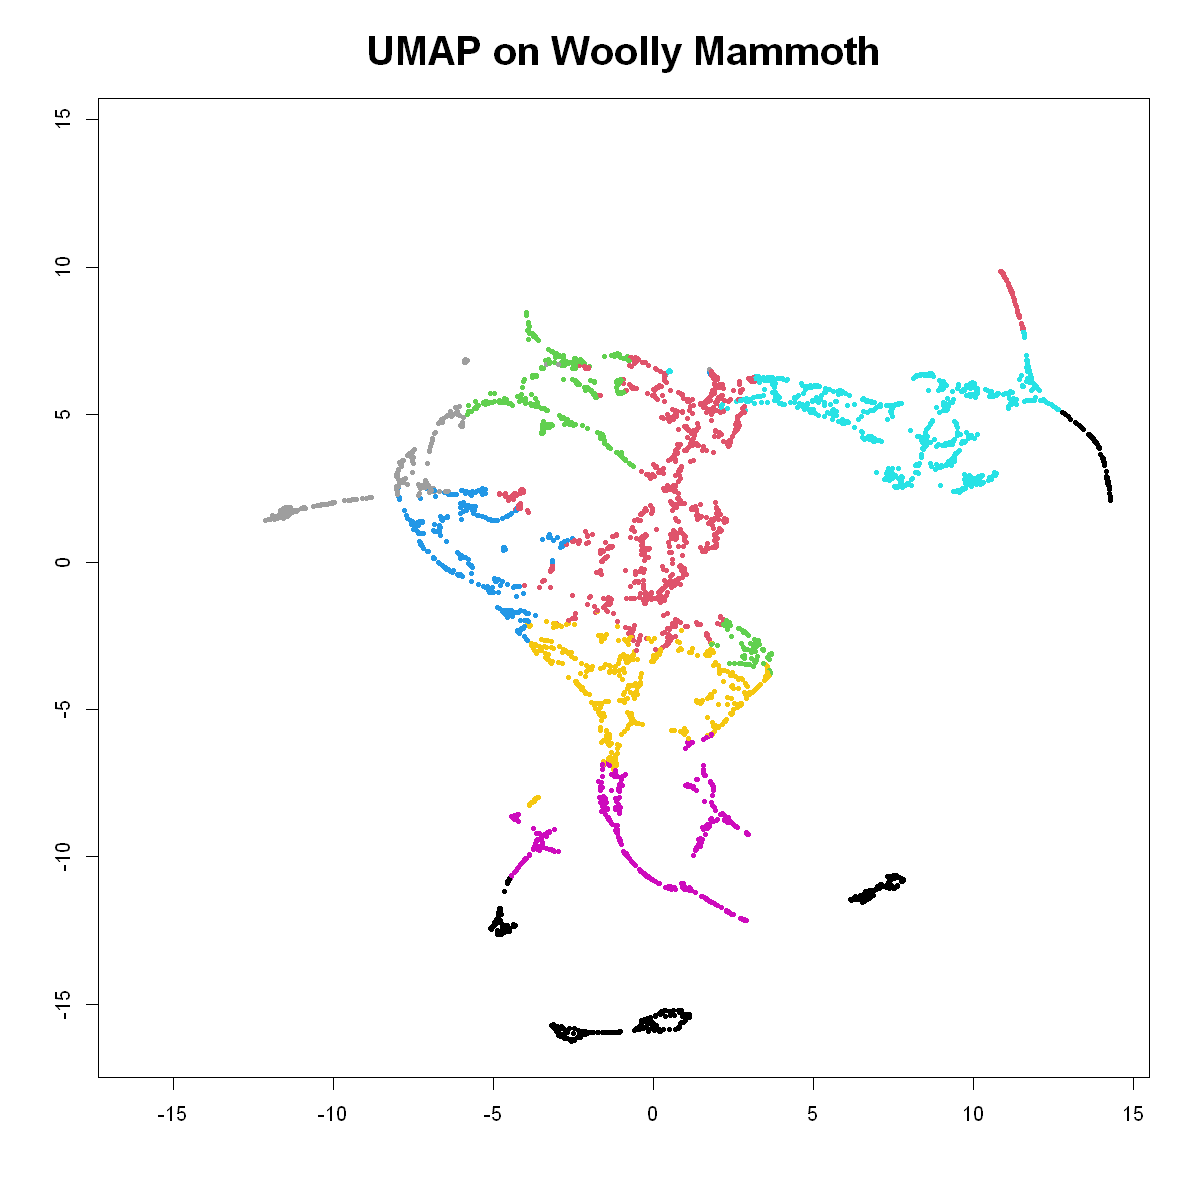

In [61]:
# plot the 2D low dimensional space (embedding)
options(repr.plot.width=10, repr.plot.height=10)
plot(mammoth_2d$layout[,1], mammoth_2d$layout[,2], col=mammoth_color, pch=19,
        main="UMAP on Woolly Mammoth", xlab="", ylab="", cex=0.5, cex.main=2)


If your computer is too slow or you do not want to wait 30 seconds for the algorithm to converge, you can also check out this website programmed by Andy Coenen and Adam Pearce [https://pair-code.github.io/understanding-umap/](https://pair-code.github.io/understanding-umap/). It is highly interactive and gives some very nice insight into how UMAP visualizes different data sets. If you scroll down a bit there is also the mammoth data set example present.

Effect of changing the `n_neighbors` paramter:

![](./lecture_plots/anim_nearest_neighbours_works.gif)


Effect of changing the `min_dist` paramter:

![](./lecture_plots/anim_min_dist_works.gif)

### Strengths of UMAP 

Before UMAP was created an algorithm called t-SNE was the go-to dimensionality reduction technique for visualization purposes. t-SNE and UMAP are very similar in how they work and are therefore often compared to one another. However UMAP is better than t-SNE in almost every regard:

* UMAP can reduce from high dimensionality to any low dimensional space. t-SNE can only reduce to 2D or 3D space.

* UMAP is more deterministic. Both UMAP and t-SNE have stochastic elements in their algorithm but since UMAP uses the spectral embedding, it often gives very similar clustering results between different runs. You can observe this in the gif above. Changing the hyperparameter `n_neighbor` for example resulted in similar 2D scatter plots with a seamless transition between each plot. Whereas t-SNE's outcome might change completely from one run to the next. 

* UMAP runs a lot faster. t-SNE uses regular gradient descent, whereas UMAP uses stochastic gradient descent, which means it only calculates the gradient on a subset of the data, not on all of them, which also scales a lot better for very large data sets.

* UMAP preserves global structure of the high dimensional space better because of how its cost function is defined. t-SNE can only preserve the local structure of the high dimensional data well.

### Weaknesses of UMAP

* On the website [Understanding UMAP](https://pair-code.github.io/understanding-umap/) by Andy Coenen and Adam Pearce in the chapter 'UMAP vs t-SNE, revisited' there is an example listed where t-SNE performs better than UMAP on a specific data set. Although UMAP tries to combat the curse of dimensionality by decreasing its high dimensional edge weights after the nearest neighbor exponentially and therefore trying to negate that distances between points in high dimensions tend to be very similar, UMAP fails to do so if the distances of points are very similar.

* UMAP lacks interpretability. Unlike PCA, which gives the direction of the highest variances in the data, the axis of a UMAP plot are meaningless. Only the distance between the points in low dimensions are relevant.



## (4) Sources

* UMAP documentation [https://umap-learn.readthedocs.io/en/latest/how_umap_works.html](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html)

* UMAP: Mathematical Details by 'StatQuest with Josh Starmer' [https://youtu.be/jth4kEvJ3P8](https://youtu.be/jth4kEvJ3P8)

* original UMAP paper by Leland McInnes [https://arxiv.org/pdf/1802.03426.pdf](https://arxiv.org/pdf/1802.03426.pdf)

* How to create gifs with gganimate in R [https://github.com/MNoichl/UMAP-examples-mammoth-/blob/master/umammoth.ipynb](https://github.com/MNoichl/UMAP-examples-mammoth-/blob/master/umammoth.ipynb)

* UMAP from scratch by Nikolay Oskolkov [https://towardsdatascience.com/how-exactly-umap-works-13e3040e1668](https://towardsdatascience.com/how-exactly-umap-works-13e3040e1668)

* SciPy talk by Leland McInnes (2018) [https://youtu.be/nq6iPZVUxZU](https://youtu.be/nq6iPZVUxZU)